# Optimize the design of the transmon pocket

To keep the structure roughly the same, we change the width of the metal pad in the transmon pocket. Intuitively, the wider the transmon pocket, the larger the capacitance would be. To increase the qubit frequency, we need to increase the capacitance.

## Steps
1. Construct the function that takes in padwidth and return a capacitance between ground and the metal pad
2. Function that takes in frequency and spit out desired capacitance
3. Optimize and find the desired design

In [1]:

import astropy.units as u
import astropy.constants as c
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize
from scipy import stats

%matplotlib inline

In [2]:
phi0 = c.h/2/c.e.si
T = 30*u.mK
epsilon_r = 11.7

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
#This imports the necessary path to draw the single pad transmon design. 
import sys
sys.path.append('Customized_Components')
from single_pad_transmon_pocket import TransmonPocket_Single

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [5]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

In [6]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

### Construct a single transmon pad to test the code

In [7]:
design.overwrite_enabled = True #This makes it possible to edit the designs later on. 

design.delete_all_components()

options = dict(pad_width = '200um',
pocket_width = '300um',
pad_pocket_distance_top = '60um',
pos_x = '0',
pad_height = '200um',
pos_y = '0',
connection_pads = dict(
    a = dict(loc_W  = 1, 
             loc_H =  1, 
             pad_gap = '10um',
             pad_height = '20um',
             pad_width = '100um',
             pad_cpw_extent =  '10um',
             pocket_rise = '0um',
             cpw_extend = '0um')))

q1 = TransmonPocket_Single(design,'Q1',options = options)

gui.rebuild()
gui.zoom_on_components(['Q1'])

In [8]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [9]:
q1.options.hfss_inductance = '12nH'

In [10]:
c1.sim.setup.min_passes  = 1
c1.sim.setup.max_passes = 5
print(c1.sim.setup)

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'freq_ghz': 5.0, 'save_fields': False, 'enabled': True, 'max_passes': 5, 'min_passes': 1, 'min_converged_passes': 2, 'percent_error': 0.5, 'percent_refinement': 30, 'auto_increase_solution_order': True, 'solution_order': 'High', 'solver_type': 'Iterative'}


In [11]:
c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix

INFO 07:54PM [connect_project]: Connecting to Ansys Desktop API...
INFO 07:54PM [load_ansys_project]: 	Opened Ansys App
INFO 07:54PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 07:54PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project22
INFO 07:54PM [connect_design]: No active design found (or error getting active design).
INFO 07:54PM [connect]: 	 Connected to project "Project22". No design detected
INFO 07:54PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
WARNING 07:54PM [connect_setup]: 	No design setup detected.
WARNING 07:54PM [connect_setup]: 	Creating Q3D default setup.
INFO 07:54PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 07:54PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 07:54PM [analyze]: Analyzing setup Setup
INFO 07:55PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Tem

In [12]:
c_mat

,a_connector_pad_Q1,ground_main_plane,pad_top_Q1
a_connector_pad_Q1,23.15782,-13.23210,-9.54623
ground_main_plane,-13.23210,120.57243,-65.70465
pad_top_Q1,-9.54623,-65.70465,78.76189


In [13]:
C = c_mat['ground_main_plane']['a_connector_pad_Q1']

In [14]:
C

-13.2321

### change w.r.t. gap distance

Find the change of capacitance, frequency w.r.t. the gap distance on both sides of a transmon

In [15]:
def find_Cap(gap):
    if type(gap)== u.quantity.Quantity:
        gap = gap.to(u.um)
    elif type(gap) == np.ndarray:
        gap = gap[0]*u.um
    design.delete_all_components()
    
    width = 300*u.um-2*gap

    options = dict(pad_width = '{}'.format(width),
    pocket_width = '{}'.format(350*u.um),
    pad_pocket_distance_top = '30um',
    pos_x = '0',
    pad_height = '250um',
    jj_length = '30um',
    pos_y = '0',
    connection_pads = dict(
        a = dict(loc_W  = 1, 
                loc_H =  1, 
                pad_gap = '10um',
                pad_height = '15um',
                pad_width = '60um',
                pad_cpw_extent =  '1um',
                pocket_rise = '0um',
                cpw_extend = '0')))

    q1 = TransmonPocket_Single(design,'Q1',options = options)

    gui.rebuild()
    gui.zoom_on_components(['Q1'])
    
    
    c1 = LOManalysis(design, "q3d")
    c1.sim.setup.min_passes  = 5
    c1.sim.setup.max_passes = 30
    
    c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
    c1.sim.capacitance_matrix 

    c1.sim._get_results_from_renderer()
    c_mat = c1.sim.capacitance_matrix
    
    print(c_mat)
    
    return((-c_mat['ground_main_plane']['pad_top_Q1'])*u.fF, design)
    

In [16]:
#Check the capacitance function is working
find_Cap(15*u.um)

INFO 07:55PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 07:55PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 07:55PM [analyze]: Analyzing setup Setup
INFO 07:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptolro4mt.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 07:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpp6kdct1n.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 07:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpt9mw6moo.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 07:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8ycxunvx.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.50071          -13.03197    -5.30278
ground_main_plane            -13.03197          158.45993  -104.65967
pad_top_Q1                    -5.30278         -104.65967   115.12254


(<Quantity 104.65967 fF>,
 <qiskit_metal.designs.design_planar.DesignPlanar at 0x2dcd5f06230>)

In [17]:
from qiskit_metal.analyses.quantization import EPRanalysis
import pandas as pd

In [18]:
# hfss = eig_qb.sim.renderer
# hfss.clean_active_design()

### Check frequency shift

In [19]:
gap_min = 15
gap_max = 55

gaps = np.linspace(gap_min*u.um, gap_max*u.um, 30)
caps = []
convergences = []
dats = []
freqs = []


qcomps = design.components  # short handle (alias)
qcomps['Q1'].options['hfss_inductance'] = 'Lj1'
qcomps['Q1'].options['hfss_capacitance'] = 'Cj1'
gui.rebuild()  # line needed to propagate the updates from the qubit instance into the junction design table
gui.autoscale()

for i, gap in enumerate(gaps):
    capacitance, design = find_Cap(gap)
    caps += [capacitance]
    
    q1.options.hfss_inductance = '13 nH'
    gui.rebuild()  # line needed to propagate the updates from the qubit instance into the junction design table
    gui.autoscale()
    
    eig_qb = EPRanalysis(design, 'hfss')
    
    eig_qb.sim.setup.max_passes = 25
    eig_qb.sim.setup.max_delta_f = 0.05
    eig_qb.sim.setup.n_modes = 1
    eig_qb.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF')
    print(eig_qb.sim.setup)
    
    eig_qb.sim.renderer.options['x_buffer_width_mm'] = 0.5
    eig_qb.sim.renderer.options['y_buffer_width_mm'] = 0.5
    print(eig_qb.sim.renderer.options)
    
    eig_qb.sim.run(name="Transmons_{}".format(i), components=['Q1'], open_terminations=[('Q1', 'a')])
    convergence = pd.read_csv('hfss_eig_f_convergence.csv')
    convergences+=[convergence]
    
    del eig_qb.setup.junctions['jj']
    eig_qb.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                  Lj_variable='Lj1', Cj_variable='Cj1')
    eig_qb.setup.sweep_variable = 'Lj1'
    eig_qb.run_epr()
    
    dats += [eig_qb.sim.renderer.epr_quantum_analysis.get_chis().to_numpy()[0][0]]
    freqs += [eig_qb.sim.renderer.epr_quantum_analysis.get_frequencies().to_numpy()[0][0]]


INFO 07:56PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 07:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 07:56PM [analyze]: Analyzing setup Setup
INFO 07:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpno73gecv.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 07:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpecia1kdg.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 07:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgp49tvu1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 07:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgh67_hru.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.50071          -13.03197    -5.30278
ground_main_plane            -13.03197          158.45993  -104.65967
pad_top_Q1                    -5.30278         -104.65967   115.12254
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 07:56PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 07:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 07:56PM [connect]: 	Connected to project "Project22" and design "Design_q3d" 😀 

INFO 07:56PM [connect_design]: 	Opened active design
	Design:    Transmons_0_hfss [Solution type: Eigenmode]
WARNING 07:56PM [connect_setup]: 	No design setup detected.
WARNING 07:56PM [connect_setup]: 	Creating eigenmode default setup.
INFO 07:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 07:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 07:56PM [analyze]: Analyzing setup Setup
07:58PM 42s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_0_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_0_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.10858233402441e-25
        energy_elec_substrate = 1.94369674120794e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.5782210144367e-27
        energy_mag % of energy_elec_all  = 0.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.61 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%  1.054e-25 7.891e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.86%
	jj1             0.762457  (+)        0.0166645
		(U_tot_cap-U_tot_ind)/mean=13.81%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218026300629334


  options=pd.Series(get_instance_vars(self.options)),

WARNING 07:58PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 07:58PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 07:58PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_0_hfss\2023-02-19 19-58-43.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.322233
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
       jj1
0  0.74996

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       208

*** Chi matrix ND (MHz) 
       230

*** Frequencies O1 PT (MHz)
0    4406.325523
dtype: float64

*** Frequencies ND (MHz)
0    4395.921025
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4395.92


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,230.1


07:58PM 47s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 07:58PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 07:58PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 07:58PM [analyze]: Analyzing setup Setup
INFO 07:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8dxcn7x_.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 07:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7hqhnwjm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 07:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9mzu5zen.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.70581          -13.20640    -5.33037
ground_main_plane            -13.20640          157.56035  -103.55474
pad_top_Q1                    -5.33037         -103.55474   114.00923
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 07:59PM [connect_design]: 	Opened active design
	Design:    Transmons_1_hfss [Solution type: Eigenmode]
WARNING 07:59PM [connect_setup]: 	No design setup detected.
WARNING 07:59PM [connect_setup]: 	Creating eigenmode default setup.
INFO 07:59PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 07:59PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 07:59PM [analyze]: Analyzing setup Setup
08:01PM 43s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_1_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_1_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.53789218390708e-25
        energy_elec_substrate = 1.41765662298653e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.15465549079621e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.64 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  7.689e-26 5.773e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.84%
	jj1             0.763055  (+)        0.0168517
		(U_tot_cap-U_tot_ind)/mean=13.78%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218179517532326


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:01PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:01PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:01PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_1_hfss\2023-02-19 20-01-43.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.32141
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
       jj1
0  0.75041

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       210

*** Chi matrix ND (MHz) 
       233

*** Frequencies O1 PT (MHz)
0    4428.186544
dtype: float64

*** Frequencies ND (MHz)
0    4417.613786
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4417.61


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,232.61


INFO 08:01PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:01PM [analyze]: Analyzing setup Setup
INFO 08:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpaug1lb_3.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvgygy385.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8jw1zj_0.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpj1rrc_68.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.71801          -13.22081    -5.33343
ground_main_plane            -13.22081          156.49246  -102.13268
pad_top_Q1                    -5.33343         -102.13268   112.56847
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:02PM [connect_design]: 	Opened active design
	Design:    Transmons_2_hfss [Solution type: Eigenmode]
WARNING 08:02PM [connect_setup]: 	No design setup detected.
WARNING 08:02PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:02PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:02PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:02PM [analyze]: Analyzing setup Setup
08:04PM 34s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_2_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_2_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 9.40251170469275e-26
        energy_elec_substrate = 8.66712702195442e-26
        EPR of substrate = 92.2%

        energy_mag    = 7.06748509712507e-28
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.66 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  4.701e-26 3.534e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.82%
	jj1             0.762433  (+)        0.0169975
		(U_tot_cap-U_tot_ind)/mean=13.83%


  sol = sol.append(self.get_Qdielectric(



Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.921788485264921


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:04PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:04PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:04PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_2_hfss\2023-02-19 20-04-34.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.322662
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.749691

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       212

*** Chi matrix ND (MHz) 
       235

*** Frequencies O1 PT (MHz)
0    4448.114593
dtype: float64

*** Frequencies ND (MHz)
0    4437.386233
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4437.39


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,234.91


08:04PM 38s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 08:04PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:04PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:04PM [analyze]: Analyzing setup Setup
INFO 08:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjaoqlvxl.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_ji9p6u1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvd93lzjt.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.89206          -13.37719    -5.34848
ground_main_plane            -13.37719          155.67337  -101.13441
pad_top_Q1                    -5.34848         -101.13441   111.55488
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:05PM [connect_design]: 	Opened active design
	Design:    Transmons_3_hfss [Solution type: Eigenmode]
WARNING 08:05PM [connect_setup]: 	No design setup detected.
WARNING 08:05PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:05PM [analyze]: Analyzing setup Setup
08:07PM 19s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_3_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_3_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.686703815095e-25
        energy_elec_substrate = 1.55477385993999e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.26915691185185e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.68 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  8.434e-26 6.346e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.80%
	jj1             0.763189  (+)        0.017176
		(U_tot_cap-U_tot_ind)/mean=13.79%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.921782381723267


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:07PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:07PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:07PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_3_hfss\2023-02-19 20-07-19.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.321578
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.750302

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       214

*** Chi matrix ND (MHz) 
       237

*** Frequencies O1 PT (MHz)
0    4468.186086
dtype: float64

*** Frequencies ND (MHz)
0    4457.298878
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4457.3


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,237.25


INFO 08:07PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:07PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:07PM [analyze]: Analyzing setup Setup
INFO 08:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3_e70979.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptpg051bx.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgh9veppb.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptzceu4ay.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.12040          -13.57095    -5.38017
ground_main_plane            -13.57095          154.89742  -100.22896
pad_top_Q1                    -5.38017         -100.22896   110.65445
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:08PM [connect_design]: 	Opened active design
	Design:    Transmons_4_hfss [Solution type: Eigenmode]
WARNING 08:08PM [connect_setup]: 	No design setup detected.
WARNING 08:08PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:08PM [analyze]: Analyzing setup Setup
08:09PM 46s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_4_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_4_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.80742103954053e-25
        energy_elec_substrate = 1.66601774594771e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.36220751016396e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.70 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  9.037e-26 6.811e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.78%
	jj1              0.76318  (+)        0.0173334
		(U_tot_cap-U_tot_ind)/mean=13.79%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9217651612439088


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:09PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:09PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:09PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_4_hfss\2023-02-19 20-09-47.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.321782
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.750177

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       216

*** Chi matrix ND (MHz) 
       240

*** Frequencies O1 PT (MHz)
0    4487.659851
dtype: float64

*** Frequencies ND (MHz)
0    4476.617462
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4476.62


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,239.52


INFO 08:09PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:09PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:09PM [analyze]: Analyzing setup Setup
INFO 08:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6ujhr7vx.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcbbdkd_n.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpg03jwx2q.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6pp7w8s_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.30613          -13.72961    -5.40467
ground_main_plane            -13.72961          154.01175   -99.18714
pad_top_Q1                    -5.40467          -99.18714   109.60286
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:10PM [connect_design]: 	Opened active design
	Design:    Transmons_5_hfss [Solution type: Eigenmode]
WARNING 08:10PM [connect_setup]: 	No design setup detected.
WARNING 08:10PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:10PM [analyze]: Analyzing setup Setup
08:12PM 08s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_5_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_5_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.84135748035398e-25
        energy_elec_substrate = 2.6189836451053e-25
        EPR of substrate = 92.2%

        energy_mag    = 2.27036188035439e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.73 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  1.421e-25 1.135e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 97.76%
	jj1             0.762795  (+)        0.017485
		(U_tot_cap-U_tot_ind)/mean=13.80%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9217367625206468


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:12PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:12PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:12PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_5_hfss\2023-02-19 20-12-08.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.32197
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.749687

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       218

*** Chi matrix ND (MHz) 
       242

*** Frequencies O1 PT (MHz)
0    4507.607547
dtype: float64

*** Frequencies ND (MHz)
0    4496.436362
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4496.44


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,241.57


INFO 08:12PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:12PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:12PM [analyze]: Analyzing setup Setup
INFO 08:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmph7naeljx.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0xawdu75.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_70x36a2.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpu_th45xy.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.50600          -13.89984    -5.43161
ground_main_plane            -13.89984          153.20022   -98.17766
pad_top_Q1                    -5.43161          -98.17766   108.58999
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:12PM [connect_design]: 	Opened active design
	Design:    Transmons_6_hfss [Solution type: Eigenmode]
WARNING 08:12PM [connect_setup]: 	No design setup detected.
WARNING 08:12PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:12PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:12PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:12PM [analyze]: Analyzing setup Setup
08:14PM 20s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_6_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_6_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.66083494987425e-25
        energy_elec_substrate = 1.53078858411748e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.34454537640223e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.75 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  8.304e-26 6.723e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 97.74%
	jj1             0.762393  (+)        0.0176374
		(U_tot_cap-U_tot_ind)/mean=13.82%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.921698200193453


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:14PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:14PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:14PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_6_hfss\2023-02-19 20-14-21.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.322708
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.749179

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       220

*** Chi matrix ND (MHz) 
       244

*** Frequencies O1 PT (MHz)
0    4527.440418
dtype: float64

*** Frequencies ND (MHz)
0    4516.115249
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4516.12


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,243.84


INFO 08:14PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:14PM [analyze]: Analyzing setup Setup
INFO 08:15PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7se85s4j.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:15PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpohspv37r.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:15PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpeu4cmlfz.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:15PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp4vp9jj9y.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.68864          -14.05581    -5.45547
ground_main_plane            -14.05581          152.29649   -97.09452
pad_top_Q1                    -5.45547          -97.09452   107.49670
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:15PM [connect_design]: 	Opened active design
	Design:    Transmons_7_hfss [Solution type: Eigenmode]
WARNING 08:15PM [connect_setup]: 	No design setup detected.
WARNING 08:15PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:15PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:15PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:15PM [analyze]: Analyzing setup Setup
08:16PM 39s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_7_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_7_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.20713434883574e-25
        energy_elec_substrate = 2.03430829642323e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.74814153145151e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.77 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  1.104e-25 8.741e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 97.72%
	jj1             0.763151  (+)        0.0178272
		(U_tot_cap-U_tot_ind)/mean=13.79%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.921696632330662


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:16PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:16PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:16PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_7_hfss\2023-02-19 20-16-40.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.321906
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.749785

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       222

*** Chi matrix ND (MHz) 
       246

*** Frequencies O1 PT (MHz)
0    4548.307516
dtype: float64

*** Frequencies ND (MHz)
0    4536.79722
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4536.8


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,246.45


INFO 08:16PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:16PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:16PM [analyze]: Analyzing setup Setup
INFO 08:17PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpz4ppmsvj.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:17PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwny0s7h3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:17PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphx8dp34k.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:17PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpclufde4o.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.87865          -14.22134    -5.47714
ground_main_plane            -14.22134          151.50610   -96.11010
pad_top_Q1                    -5.47714          -96.11010   106.50176
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:17PM [connect_design]: 	Opened active design
	Design:    Transmons_8_hfss [Solution type: Eigenmode]
WARNING 08:17PM [connect_setup]: 	No design setup detected.
WARNING 08:17PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:17PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:17PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:17PM [analyze]: Analyzing setup Setup
08:19PM 09s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_8_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_8_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.96439933057727e-25
        energy_elec_substrate = 1.81069273076562e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.49180581718456e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.79 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  9.822e-26 7.459e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.69%
	jj1             0.762373  (+)        0.0179913
		(U_tot_cap-U_tot_ind)/mean=13.87%


  sol = sol.append(self.get_Qdielectric(



Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9217538932033331


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:19PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:19PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:19PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_8_hfss\2023-02-19 20-19-10.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.32395
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.748899

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       225

*** Chi matrix ND (MHz) 
       249

*** Frequencies O1 PT (MHz)
0    4570.217861
dtype: float64

*** Frequencies ND (MHz)
0    4558.500512
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4558.5


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,249.31


INFO 08:19PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:19PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:19PM [analyze]: Analyzing setup Setup
INFO 08:19PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9pxk5c4v.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:19PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpeypm1w4l.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:19PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpaei3_9az.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:19PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpect8onjx.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.14139          -14.43270    -5.52557
ground_main_plane            -14.43270          150.85890   -95.24235
pad_top_Q1                    -5.52557          -95.24235   105.65402
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:20PM [connect_design]: 	Opened active design
	Design:    Transmons_9_hfss [Solution type: Eigenmode]
WARNING 08:20PM [connect_setup]: 	No design setup detected.
WARNING 08:20PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:20PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:20PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:20PM [analyze]: Analyzing setup Setup
08:21PM 17s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_9_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_9_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.97042446113377e-25
        energy_elec_substrate = 2.73778622577119e-25
        EPR of substrate = 92.2%

        energy_mag    = 2.35664010005348e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.81 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  1.485e-25 1.178e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 97.68%
	jj1             0.763134  (+)        0.0181558
		(U_tot_cap-U_tot_ind)/mean=13.81%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.921681820761136


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:21PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:21PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:21PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_9_hfss\2023-02-19 20-21-17.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.322344
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.749526

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       226

*** Chi matrix ND (MHz) 
       251

*** Frequencies O1 PT (MHz)
0    4588.029415
dtype: float64

*** Frequencies ND (MHz)
0    4576.187277
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4576.19


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,251.22


INFO 08:21PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:21PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:21PM [analyze]: Analyzing setup Setup
INFO 08:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwv_ur5yf.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvw_ydc5b.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmjvbw_sj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqrma2737.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.33292          -14.60589    -5.54222
ground_main_plane            -14.60589          150.19147   -94.31917
pad_top_Q1                    -5.54222          -94.31917   104.70621
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:22PM [connect_design]: 	Opened active design
	Design:    Transmons_10_hfss [Solution type: Eigenmode]
WARNING 08:22PM [connect_setup]: 	No design setup detected.
WARNING 08:22PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:22PM [analyze]: Analyzing setup Setup
08:23PM 22s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_10_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_10_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.76137623453129e-25
        energy_elec_substrate = 2.54520573751996e-25
        EPR of substrate = 92.2%

        energy_mag    = 2.22794960379168e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.84 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  1.381e-25 1.114e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 97.65%
	jj1             0.763118  (+)        0.0183283
		(U_tot_cap-U_tot_ind)/mean=13.81%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9217163911573889


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:23PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:23PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:23PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_10_hfss\2023-02-19 20-23-22.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.322398
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.749383

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       228

*** Chi matrix ND (MHz) 
       254

*** Frequencies O1 PT (MHz)
0    4608.813073
dtype: float64

*** Frequencies ND (MHz)
0    4596.804452
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4596.8


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,253.64


INFO 08:23PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:23PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:23PM [analyze]: Analyzing setup Setup
INFO 08:24PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwv634kx2.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:24PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3v82win5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:24PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprogzqgqw.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:24PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcjnbqpy6.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.49785          -14.74753    -5.56246
ground_main_plane            -14.74753          149.40740   -93.36349
pad_top_Q1                    -5.56246          -93.36349   103.73742
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:24PM [connect_design]: 	Opened active design
	Design:    Transmons_11_hfss [Solution type: Eigenmode]
WARNING 08:24PM [connect_setup]: 	No design setup detected.
WARNING 08:24PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:24PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:24PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:24PM [analyze]: Analyzing setup Setup
08:25PM 19s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_11_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_11_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.86935998836475e-25
        energy_elec_substrate = 2.64456432682363e-25
        EPR of substrate = 92.2%

        energy_mag    = 2.27969829822034e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.86 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  1.435e-25  1.14e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 97.63%
	jj1             0.762359  (+)        0.0184697
		(U_tot_cap-U_tot_ind)/mean=13.87%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9216565148839233


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:25PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:25PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:25PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_11_hfss\2023-02-19 20-25-19.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.324077
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.748534

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       230

*** Chi matrix ND (MHz) 
       256

*** Frequencies O1 PT (MHz)
0    4627.796823
dtype: float64

*** Frequencies ND (MHz)
0    4615.615705
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4615.62


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,256.04


INFO 08:25PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:25PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:25PM [analyze]: Analyzing setup Setup
INFO 08:26PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_zibqrwa.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:26PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpbqn7vff5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:26PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwpjo2go5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:26PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpe3navr3u.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.67094          -14.89990    -5.58006
ground_main_plane            -14.89990          148.62082   -92.38969
pad_top_Q1                    -5.58006          -92.38969   102.74821
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:26PM [connect_design]: 	Opened active design
	Design:    Transmons_12_hfss [Solution type: Eigenmode]
WARNING 08:26PM [connect_setup]: 	No design setup detected.
WARNING 08:26PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:26PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:26PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:26PM [analyze]: Analyzing setup Setup
08:27PM 51s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_12_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_12_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.96155509569123e-25
        energy_elec_substrate = 1.8082093908543e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.50159444241401e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.89 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  9.808e-26 7.508e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.61%
	jj1             0.763089  (+)        0.0187088
		(U_tot_cap-U_tot_ind)/mean=13.86%


  sol = sol.append(self.get_Qdielectric(



Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218244212595554


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:27PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:27PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:27PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_12_hfss\2023-02-19 20-27-51.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.323558
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.749075

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       233

*** Chi matrix ND (MHz) 
       259

*** Frequencies O1 PT (MHz)
0    4653.896658
dtype: float64

*** Frequencies ND (MHz)
0    4641.465033
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4641.47


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,259.47


INFO 08:27PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:27PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:27PM [analyze]: Analyzing setup Setup
INFO 08:28PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpyih9lrd6.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:28PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpc04p_2f7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:28PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkzl2vil5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:28PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9sy33df3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.84003          -15.04716    -5.59888
ground_main_plane            -15.04716          147.85288   -91.44488
pad_top_Q1                    -5.59888          -91.44488   101.78911
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:28PM [connect_design]: 	Opened active design
	Design:    Transmons_13_hfss [Solution type: Eigenmode]
WARNING 08:28PM [connect_setup]: 	No design setup detected.
WARNING 08:28PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:28PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:28PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:28PM [analyze]: Analyzing setup Setup
08:31PM 29s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_13_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_13_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 7.53658927708032e-26
        energy_elec_substrate = 6.94828743106812e-26
        EPR of substrate = 92.2%

        energy_mag    = 5.79396007712451e-28
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.92 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  3.768e-26 2.897e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 97.58%
	jj1             0.762652  (+)        0.0189112
		(U_tot_cap-U_tot_ind)/mean=13.89%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9219405722690371


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:31PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:31PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:31PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_13_hfss\2023-02-19 20-31-29.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.324531
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.748497

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       236

*** Chi matrix ND (MHz) 
       263

*** Frequencies O1 PT (MHz)
0    4679.021164
dtype: float64

*** Frequencies ND (MHz)
0    4666.37049
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4666.37


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,262.55


08:31PM 34s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 08:31PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:31PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:31PM [analyze]: Analyzing setup Setup
INFO 08:32PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpo9f9w8fx.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:32PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvy55n3gf.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:32PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpy4xqk3we.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.03080          -15.20784    -5.62613
ground_main_plane            -15.20784          147.15619   -90.56703
pad_top_Q1                    -5.62613          -90.56703   100.90716
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:32PM [connect_design]: 	Opened active design
	Design:    Transmons_14_hfss [Solution type: Eigenmode]
WARNING 08:32PM [connect_setup]: 	No design setup detected.
WARNING 08:32PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:32PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:32PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:32PM [analyze]: Analyzing setup Setup
08:33PM 47s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_14_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_14_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.70182647780734e-25
        energy_elec_substrate = 1.56860985948768e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.42766706953636e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.93 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  8.509e-26 7.138e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 97.56%
	jj1             0.762678  (+)        0.0190406
		(U_tot_cap-U_tot_ind)/mean=13.85%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9217213857835268


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:33PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:33PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:33PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_14_hfss\2023-02-19 20-33-47.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.323612
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.748427

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       237

*** Chi matrix ND (MHz) 
       264

*** Frequencies O1 PT (MHz)
0    4694.48954
dtype: float64

*** Frequencies ND (MHz)
0    4681.758624
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4681.76


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,263.94


INFO 08:33PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:33PM [analyze]: Analyzing setup Setup
INFO 08:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0g4l2bxg.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpl_j6vmhk.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpegcwjbaf.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkva_ngof.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.22900          -15.37688    -5.65216
ground_main_plane            -15.37688          146.42678   -89.64088
pad_top_Q1                    -5.65216          -89.64088    99.97403
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:34PM [connect_design]: 	Opened active design
	Design:    Transmons_15_hfss [Solution type: Eigenmode]
WARNING 08:34PM [connect_setup]: 	No design setup detected.
WARNING 08:34PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:34PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:34PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:34PM [analyze]: Analyzing setup Setup
08:36PM 17s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_15_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_15_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 9.69010321447371e-26
        energy_elec_substrate = 8.93240345292066e-26
        EPR of substrate = 92.2%

        energy_mag    = 7.45937516987154e-28
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.96 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  4.845e-26  3.73e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.54%
	jj1             0.762586  (+)        0.0192376
		(U_tot_cap-U_tot_ind)/mean=13.91%


  sol = sol.append(self.get_Qdielectric(



Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.921806843045665


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:36PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:36PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:36PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_15_hfss\2023-02-19 20-36-18.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.325055
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.748193

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       240

*** Chi matrix ND (MHz) 
       267

*** Frequencies O1 PT (MHz)
0    4717.380118
dtype: float64

*** Frequencies ND (MHz)
0    4704.386128
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4704.39


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,267.33


INFO 08:36PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:36PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:36PM [analyze]: Analyzing setup Setup
INFO 08:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqqdv1fkz.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpu9w0jx6p.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp5c3szc9j.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8h6hfbt0.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.40101          -15.52869    -5.66936
ground_main_plane            -15.52869          145.69041   -88.72302
pad_top_Q1                    -5.66936          -88.72302    99.04051
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:37PM [connect_design]: 	Opened active design
	Design:    Transmons_16_hfss [Solution type: Eigenmode]
WARNING 08:37PM [connect_setup]: 	No design setup detected.
WARNING 08:37PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:37PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:37PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:37PM [analyze]: Analyzing setup Setup
08:38PM 15s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_16_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_16_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.37624881977529e-25
        energy_elec_substrate = 2.1900236383828e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.97216461805964e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.97 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  1.188e-25 9.861e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 97.52%
	jj1             0.762303  (+)        0.0193623
		(U_tot_cap-U_tot_ind)/mean=13.90%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9216306054135777


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:38PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:38PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:38PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_16_hfss\2023-02-19 20-38-15.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.324813
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.747824

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       241

*** Chi matrix ND (MHz) 
       269

*** Frequencies O1 PT (MHz)
0    4733.022215
dtype: float64

*** Frequencies ND (MHz)
0    4719.937027
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4719.94


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,268.83


INFO 08:38PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:38PM [analyze]: Analyzing setup Setup
INFO 08:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgryg3k0b.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkyhazorm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgothqwx4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp47niy8fl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.57850          -15.67813    -5.69430
ground_main_plane            -15.67813          144.92281   -87.77628
pad_top_Q1                    -5.69430          -87.77628    98.08517
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:39PM [connect_design]: 	Opened active design
	Design:    Transmons_17_hfss [Solution type: Eigenmode]
WARNING 08:39PM [connect_setup]: 	No design setup detected.
WARNING 08:39PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:39PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:39PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:39PM [analyze]: Analyzing setup Setup
08:40PM 19s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_17_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_17_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.17145960825197e-25
        energy_elec_substrate = 2.00141229246468e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.75719480476187e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.00 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  1.086e-25 8.786e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.50%
	jj1             0.762279  (+)        0.0195679
		(U_tot_cap-U_tot_ind)/mean=13.92%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9216898554589377


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:40PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:40PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:40PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_17_hfss\2023-02-19 20-40-19.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.325431
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.747649

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       244

*** Chi matrix ND (MHz) 
       272

*** Frequencies O1 PT (MHz)
0    4756.759883
dtype: float64

*** Frequencies ND (MHz)
0    4743.439668
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4743.44


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,271.99


INFO 08:40PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:40PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:40PM [analyze]: Analyzing setup Setup
INFO 08:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpo419izzg.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpepfjlqol.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp811nn7lr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpd0dk8n2f.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.79639          -15.87928    -5.70768
ground_main_plane            -15.87928          144.25023   -86.87460
pad_top_Q1                    -5.70768          -86.87460    97.16365
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:41PM [connect_design]: 	Opened active design
	Design:    Transmons_18_hfss [Solution type: Eigenmode]
WARNING 08:41PM [connect_setup]: 	No design setup detected.
WARNING 08:41PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:41PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:41PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:41PM [analyze]: Analyzing setup Setup
08:43PM 17s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_18_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_18_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.0385173455579e-25
        energy_elec_substrate = 9.57402350172148e-26
        EPR of substrate = 92.2%

        energy_mag    = 8.0525435154095e-28
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.03 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  5.193e-26 4.026e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 97.47%
	jj1             0.763012  (+)        0.0198265
		(U_tot_cap-U_tot_ind)/mean=13.91%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218934611610399


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:43PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:43PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:43PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_18_hfss\2023-02-19 20-43-18.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.325004
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.748178

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       247

*** Chi matrix ND (MHz) 
       276

*** Frequencies O1 PT (MHz)
0    4784.10352
dtype: float64

*** Frequencies ND (MHz)
0    4770.499485
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4770.5


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,275.74


INFO 08:43PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:43PM [analyze]: Analyzing setup Setup
INFO 08:44PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp5yrdr0h8.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:44PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfeyloead.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:44PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3ox9a8zg.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:44PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpa6hgl4w0.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.95769          -16.01656    -5.72844
ground_main_plane            -16.01656          143.51045   -85.96583
pad_top_Q1                    -5.72844          -85.96583    96.24146
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:44PM [connect_design]: 	Opened active design
	Design:    Transmons_19_hfss [Solution type: Eigenmode]
WARNING 08:44PM [connect_setup]: 	No design setup detected.
WARNING 08:44PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:44PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:44PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:44PM [analyze]: Analyzing setup Setup
08:45PM 24s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_19_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_19_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.81741431942315e-25
        energy_elec_substrate = 2.59685021043085e-25
        EPR of substrate = 92.2%

        energy_mag    = 2.27819040481229e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.05 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  1.409e-25 1.139e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 97.45%
	jj1             0.762263  (+)        0.0199483
		(U_tot_cap-U_tot_ind)/mean=13.94%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9217139958891601


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:45PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:45PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:45PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_19_hfss\2023-02-19 20-45-25.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.325965
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.747355

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       249

*** Chi matrix ND (MHz) 
       278

*** Frequencies O1 PT (MHz)
0    4800.434949
dtype: float64

*** Frequencies ND (MHz)
0    4786.707183
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4786.71


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,277.56


INFO 08:45PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:45PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:45PM [analyze]: Analyzing setup Setup
INFO 08:46PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppd81ndj5.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:46PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwhgbt5c9.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:46PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprmywvxwf.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:46PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmwskcotq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.13030          -16.16765    -5.74678
ground_main_plane            -16.16765          142.73866   -85.02536
pad_top_Q1                    -5.74678          -85.02536    95.28982
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:46PM [connect_design]: 	Opened active design
	Design:    Transmons_20_hfss [Solution type: Eigenmode]
WARNING 08:46PM [connect_setup]: 	No design setup detected.
WARNING 08:46PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:46PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:46PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:46PM [analyze]: Analyzing setup Setup
08:47PM 29s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_20_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_20_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.89946105339458e-25
        energy_elec_substrate = 1.75070545046878e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.55236241138741e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.07 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  9.497e-26 7.762e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 97.43%
	jj1             0.762246  (+)        0.0201368
		(U_tot_cap-U_tot_ind)/mean=13.95%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9216853629823286


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:47PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:47PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:47PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions

  fig, axs = plt.subplots(2, 2, figsize=(10, 6))




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_20_hfss\2023-02-19 20-47-29.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.326113
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
      jj1
0  0.7472

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       251

*** Chi matrix ND (MHz) 
       280

*** Frequencies O1 PT (MHz)
0    4821.982049
dtype: float64

*** Frequencies ND (MHz)
0    4808.057993
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4808.06


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,280.26


INFO 08:47PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:47PM [analyze]: Analyzing setup Setup
INFO 08:48PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpokpp2p54.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:48PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfrk7yuov.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:48PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0lsc9k4i.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:48PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpneojadrm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.30555          -16.32489    -5.76181
ground_main_plane            -16.32489          142.09336   -84.18916
pad_top_Q1                    -5.76181          -84.18916    94.43347
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:48PM [connect_design]: 	Opened active design
	Design:    Transmons_21_hfss [Solution type: Eigenmode]
WARNING 08:48PM [connect_setup]: 	No design setup detected.
WARNING 08:48PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:48PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:48PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:48PM [analyze]: Analyzing setup Setup
08:51PM 54s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_21_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_21_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 5.41174195139814e-26
        energy_elec_substrate = 4.98970210213525e-26
        EPR of substrate = 92.2%

        energy_mag    = 4.22765634746406e-28
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.11 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  2.706e-26 2.114e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 97.39%
	jj1             0.762968  (+)        0.0204368
		(U_tot_cap-U_tot_ind)/mean=13.94%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9220140477773788


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:52PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:52PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:52PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_21_hfss\2023-02-19 20-51-55.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.32579
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.747688

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       255

*** Chi matrix ND (MHz) 
       285

*** Frequencies O1 PT (MHz)
0    4853.497314
dtype: float64

*** Frequencies ND (MHz)
0    4839.237327
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4839.24


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,284.64


08:52PM 00s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 08:52PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:52PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:52PM [analyze]: Analyzing setup Setup
INFO 08:52PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1qmpwjt5.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:52PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0jkuek8d.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:52PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvaa7gv2w.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.48237          -16.49036    -5.76987
ground_main_plane            -16.49036          141.41472   -83.31012
pad_top_Q1                    -5.76987          -83.31012    93.52722
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:52PM [connect_design]: 	Opened active design
	Design:    Transmons_22_hfss [Solution type: Eigenmode]
WARNING 08:52PM [connect_setup]: 	No design setup detected.
WARNING 08:52PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:52PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:52PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:52PM [analyze]: Analyzing setup Setup
08:54PM 35s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_22_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_22_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 9.895990897883e-26
        energy_elec_substrate = 9.1225966914455e-26
        EPR of substrate = 92.2%

        energy_mag    = 7.73454449851045e-28
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.13 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  4.948e-26 3.867e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.37%
	jj1              0.76269  (+)        0.0205841
		(U_tot_cap-U_tot_ind)/mean=13.96%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218477245565223


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:54PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:54PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:54PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_22_hfss\2023-02-19 20-54-35.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.32646
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.747307

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       257

*** Chi matrix ND (MHz) 
       287

*** Frequencies O1 PT (MHz)
0    4870.889215
dtype: float64

*** Frequencies ND (MHz)
0    4856.460418
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4856.46


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,286.91


INFO 08:54PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:54PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:54PM [analyze]: Analyzing setup Setup
INFO 08:55PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_9spz1xq.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:55PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkqz2kbib.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:55PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8xafhr9n.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 08:55PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprg5u001m.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.71031          -16.68442    -5.80048
ground_main_plane            -16.68442          140.76713   -82.44950
pad_top_Q1                    -5.80048          -82.44950    92.66400
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:55PM [connect_design]: 	Opened active design
	Design:    Transmons_23_hfss [Solution type: Eigenmode]
WARNING 08:55PM [connect_setup]: 	No design setup detected.
WARNING 08:55PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:55PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:55PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:55PM [analyze]: Analyzing setup Setup
08:57PM 28s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_23_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_23_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 8.08714701809776e-26
        energy_elec_substrate = 7.45547356793436e-26
        EPR of substrate = 92.2%

        energy_mag    = 6.32835688113069e-28
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.15 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  4.044e-26 3.164e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.35%
	jj1             0.762195  (+)        0.0207848
		(U_tot_cap-U_tot_ind)/mean=14.00%


  sol = sol.append(self.get_Qdielectric(



Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218916821037364


  options=pd.Series(get_instance_vars(self.options)),

WARNING 08:57PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:57PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.0% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:57PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.0% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_23_hfss\2023-02-19 20-57-29.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.327565
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.746676

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       260

*** Chi matrix ND (MHz) 
       290

*** Frequencies O1 PT (MHz)
0    4894.826462
dtype: float64

*** Frequencies ND (MHz)
0    4880.163392
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4880.16


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,290.04


08:57PM 34s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 08:57PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 08:57PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 08:57PM [analyze]: Analyzing setup Setup
INFO 08:58PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2syqqcbt.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:58PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpx1n6tled.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 08:58PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_8nohjbb.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.85962          -16.82621    -5.80506
ground_main_plane            -16.82621          140.06532   -81.57077
pad_top_Q1                    -5.80506          -81.57077    91.75379
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 08:58PM [connect_design]: 	Opened active design
	Design:    Transmons_24_hfss [Solution type: Eigenmode]
WARNING 08:58PM [connect_setup]: 	No design setup detected.
WARNING 08:58PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:58PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:58PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:58PM [analyze]: Analyzing setup Setup
08:59PM 58s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_24_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_24_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.63532058420373e-25
        energy_elec_substrate = 1.50751855729175e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.37142699056383e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.18 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  8.177e-26 6.857e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.32%
	jj1             0.762189  (+)        0.0209698
		(U_tot_cap-U_tot_ind)/mean=13.98%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218489462271342


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:00PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:00PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.0% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:00PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.0% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_24_hfss\2023-02-19 20-59-58.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.326983
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.746534

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       261

*** Chi matrix ND (MHz) 
       292

*** Frequencies O1 PT (MHz)
0    4915.758411
dtype: float64

*** Frequencies ND (MHz)
0    4900.941353
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4900.94


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,292.33


INFO 09:00PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:00PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:00PM [analyze]: Analyzing setup Setup
INFO 09:00PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpp5oxdc7z.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:00PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwn0tb1gb.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:00PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgvq0fjqn.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:00PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp965ldd1g.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.06990          -17.00837    -5.82972
ground_main_plane            -17.00837          139.42115   -80.72108
pad_top_Q1                    -5.82972          -80.72108    90.89646
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 09:00PM [connect_design]: 	Opened active design
	Design:    Transmons_25_hfss [Solution type: Eigenmode]
WARNING 09:00PM [connect_setup]: 	No design setup detected.
WARNING 09:00PM [connect_setup]: 	Creating eigenmode default setup.
INFO 09:00PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:00PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:00PM [analyze]: Analyzing setup Setup
09:02PM 29s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_25_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_25_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.48063973298518e-25
        energy_elec_substrate = 1.36489015898726e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.29664559863452e-27
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.20 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  7.403e-26 6.483e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.30%
	jj1             0.762936  (+)        0.0211984
		(U_tot_cap-U_tot_ind)/mean=13.92%


  sol = sol.append(self.get_Qdielectric(



Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218246198455364


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:02PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:02PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:02PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_25_hfss\2023-02-19 21-02-30.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.325435
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.747099

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       264

*** Chi matrix ND (MHz) 
       295

*** Frequencies O1 PT (MHz)
0    4938.978836
dtype: float64

*** Frequencies ND (MHz)
0    4923.965193
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4923.97


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,295.1


09:02PM 34s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 09:02PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:02PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:02PM [analyze]: Analyzing setup Setup
INFO 09:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpz7xl22l_.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1zd07ljm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpeinjqxvp.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.23940          -17.16489    -5.83959
ground_main_plane            -17.16489          138.74452   -79.85244
pad_top_Q1                    -5.83959          -79.85244    90.00040
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 09:03PM [connect_design]: 	Opened active design
	Design:    Transmons_26_hfss [Solution type: Eigenmode]
WARNING 09:03PM [connect_setup]: 	No design setup detected.
WARNING 09:03PM [connect_setup]: 	Creating eigenmode default setup.
INFO 09:03PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:03PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:03PM [analyze]: Analyzing setup Setup
09:04PM 39s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_26_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_26_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.18307516896774e-25
        energy_elec_substrate = 2.01225823944615e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.85087431014213e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.23 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  1.092e-25 9.254e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 97.27%
	jj1             0.762171  (+)        0.0213637
		(U_tot_cap-U_tot_ind)/mean=13.99%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.92175398632638


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:04PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:04PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.0% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:04PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.0% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_26_hfss\2023-02-19 21-04-39.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.327391
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.746229

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       266

*** Chi matrix ND (MHz) 
       298

*** Frequencies O1 PT (MHz)
0    4959.349786
dtype: float64

*** Frequencies ND (MHz)
0    4944.103267
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4944.1


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,298.05


INFO 09:04PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:04PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:04PM [analyze]: Analyzing setup Setup
INFO 09:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8v4xicb0.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjx5o353c.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpsvepctyl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp23w2c1hg.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.22007          -17.17083    -5.81188
ground_main_plane            -17.17083          138.05686   -78.79049
pad_top_Q1                    -5.81188          -78.79049    88.85678
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 09:05PM [connect_design]: 	Opened active design
	Design:    Transmons_27_hfss [Solution type: Eigenmode]
WARNING 09:05PM [connect_setup]: 	No design setup detected.
WARNING 09:05PM [connect_setup]: 	Creating eigenmode default setup.
INFO 09:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:05PM [analyze]: Analyzing setup Setup
09:06PM 40s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_27_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_27_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.33747796994925e-25
        energy_elec_substrate = 2.15449443420608e-25
        EPR of substrate = 92.2%

        energy_mag    = 2.06622232292804e-27
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.25 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  1.169e-25 1.033e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 97.25%
	jj1             0.762163  (+)        0.0215706
		(U_tot_cap-U_tot_ind)/mean=13.98%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9217175356963286


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:06PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:06PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.0% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:06PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.0% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_27_hfss\2023-02-19 21-06-40.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.327137
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
       jj1
0  0.74607

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       269

*** Chi matrix ND (MHz) 
       301

*** Frequencies O1 PT (MHz)
0    4982.260536
dtype: float64

*** Frequencies ND (MHz)
0    4966.816242
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4966.82


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,300.81


INFO 09:06PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:06PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:06PM [analyze]: Analyzing setup Setup
INFO 09:07PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp55g9pfyc.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:07PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1hnmu14t.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:07PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmzy4xvyo.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:07PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpevwzk6w5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.40815          -17.32232    -5.84530
ground_main_plane            -17.32232          137.40904   -77.96114
pad_top_Q1                    -5.84530          -77.96114    88.02661
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 09:07PM [connect_design]: 	Opened active design
	Design:    Transmons_28_hfss [Solution type: Eigenmode]
WARNING 09:07PM [connect_setup]: 	No design setup detected.
WARNING 09:07PM [connect_setup]: 	Creating eigenmode default setup.
INFO 09:07PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:07PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:07PM [analyze]: Analyzing setup Setup
09:09PM 30s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_28_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_28_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 8.81340874606749e-26
        energy_elec_substrate = 8.12471268010288e-26
        EPR of substrate = 92.2%

        energy_mag    = 6.97273148407998e-28
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.28 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  4.407e-26 3.486e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.21%
	jj1              0.76213  (+)        0.0218364
		(U_tot_cap-U_tot_ind)/mean=14.05%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218581498024924


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:09PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:09PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.1% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:09PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.1% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_28_hfss\2023-02-19 21-09-30.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.328924
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.745844

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       273

*** Chi matrix ND (MHz) 
       305

*** Frequencies O1 PT (MHz)
0    5010.734023
dtype: float64

*** Frequencies ND (MHz)
0    4994.900432
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4994.9


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,305.47


INFO 09:09PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:09PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:09PM [analyze]: Analyzing setup Setup
INFO 09:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1_5221go.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpidq7f43n.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgodfyvye.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpj9n_82te.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.54737          -17.44978    -5.85393
ground_main_plane            -17.44978          136.65988   -77.06878
pad_top_Q1                    -5.85393          -77.06878    87.10802
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 09:10PM [connect_design]: 	Opened active design
	Design:    Transmons_29_hfss [Solution type: Eigenmode]
WARNING 09:10PM [connect_setup]: 	No design setup detected.
WARNING 09:10PM [connect_setup]: 	Creating eigenmode default setup.
INFO 09:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:10PM [analyze]: Analyzing setup Setup
09:11PM 58s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_29_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_29_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 8.71903579565009e-26
        energy_elec_substrate = 8.03773165721654e-26
        EPR of substrate = 92.2%

        energy_mag    = 7.57290338113491e-28
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.31 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%   4.36e-26 3.786e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.19%
	jj1             0.762882  (+)        0.0220652
		(U_tot_cap-U_tot_ind)/mean=13.97%


  sol = sol.append(self.get_Qdielectric(



Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218601512367399


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:12PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:12PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:12PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_29_hfss\2023-02-19 21-11-59.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.326767
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.746412

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       275

*** Chi matrix ND (MHz) 
       308

*** Frequencies O1 PT (MHz)
0    5033.608579
dtype: float64

*** Frequencies ND (MHz)
0    5017.614906
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,5017.61


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,307.9


In [20]:
plot_cap = []
plot_freq = []
plot_freq_epr = []

for i in range(len(gaps)):
    
    plot_cap  += [caps[i].value]

    plot_freq += [pd.DataFrame.dropna(convergences[i])['re(Mode(1)) [g]'].values[-1]]
    
    # plot_freq_epr += [freqs[i][0][0]]
    


In [21]:
def freq_from_cap(Cq, lj = 12*u.nH):
    Cq *= u.fF
    # Cq = 100*u.fF
    Lj = lj
    Ec = (c.e.si**2/2/Cq).to(u.J)
    Ej = ((phi0/2/np.pi)**2/Lj).to(u.J)
    # epsilon1 = -Ec*2**9
    wq = (np.sqrt(8*Ej*Ec)-Ec)/c.hbar
    fq = wq/2/np.pi
    
    return fq

In [22]:
plt.figure()

plt.scatter(gaps.value, plot_cap)
plt.xlabel('Distance on the sides (um)')
plt.ylabel('Capacitance to Ground (fF)')
plt.show()

In [23]:
plot_freq_from_cap = freq_from_cap(plot_cap)
plot_freq_from_cap1 = freq_from_cap(plot_cap,lj = 13*u.nH)

In [40]:
%matplotlib inline

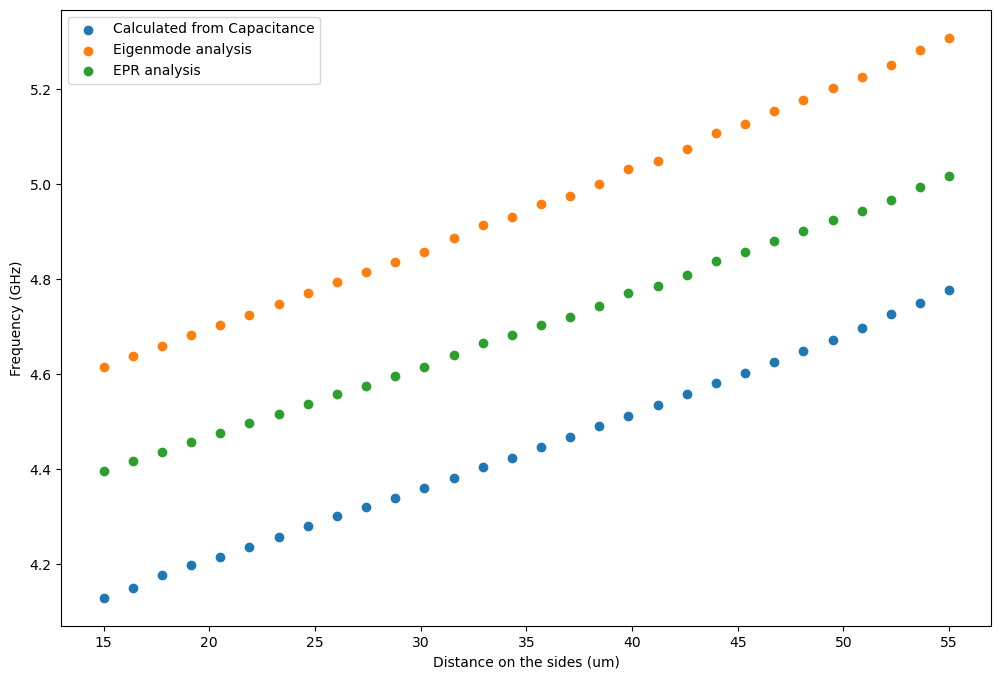

In [41]:
plt.figure(figsize = (12,8))

plt.scatter(gaps.value, plot_freq_from_cap1/1e9,label =  'Calculated from Capacitance')
# plt.scatter(gaps.value, plot_freq_from_cap1)
plt.scatter(gaps.value, np.array(plot_freq), label = 'Eigenmode analysis')
plt.scatter(gaps.value, np.array(freqs)/1e3, label = 'EPR analysis')
plt.xlabel('Distance on the sides (um)')
plt.ylabel('Frequency (GHz)')
plt.legend()
plt.savefig('transmon frequency vs gap.png')
plt.show()



In [65]:
dictionary = {}

dictionary['Pad_len (mm)'] = gaps/1000
dictionary['Pad_area (mm2)'] = (300*u.um-2*gap)*(250)/1e6
dictionary['Ground_Pad (fF)'] = plot_cap
dictionary['Finite Element Analysis Freq (GHz)'] = plot_freq
dictionary['Frequency from Capacitance (GHz)'] = plot_freq_from_cap1/1e9
dictionary['EPR Frequency (GHz)'] = np.array(freqs)/1e3
df_ = pd.DataFrame(dictionary)

In [66]:
df_

,Pad_len (mm),Pad_area (mm2),Ground_Pad (fF),Finite Element Analysis Freq (GHz),Frequency from Capacitance (GHz),EPR Frequency (GHz)
0,0.015000,0.0475,104.65967,4.614474,4.129703,4.395921
1,0.016379,0.0475,103.55474,4.638499,4.150686,4.417614
2,0.017759,0.0475,102.13268,4.660414,4.178176,4.437386
3,0.019138,0.0475,101.13441,4.682501,4.197808,4.457299
4,0.020517,0.0475,100.22896,4.703935,4.215859,4.476617
5,0.021897,0.0475,99.18714,4.725663,4.236925,4.496436
6,0.023276,0.0475,98.17766,4.747459,4.257645,4.516115
7,0.024655,0.0475,97.09452,4.770562,4.280224,4.536797
8,0.026034,0.0475,96.11010,4.794910,4.301064,4.558501
9,0.027414,0.0475,95.24235,4.814380,4.319693,4.576187


In [67]:
df_.to_csv('Frequencies from gap.csv')

## Set gap value to be 30um, change size of pocket

In [25]:
def find_Cap_h(size):
    gap = 30*u.um
    size = size.to(u.um)
    pocket_width = size+2*gap
    design.delete_all_components()

    options = dict(pad_width = '{}'.format(size),
    pocket_width = '{}'.format(pocket_width),
    pad_pocket_distance_top = '40um',
    pos_x = '0',
    pad_height = '{}um'.format(size.value),
    pos_y = '0',
    connection_pads = dict(
        a = dict(loc_W  = 1, 
                loc_H =  1, 
                pad_gap = '10um',
                pad_height = '20um',
                pad_width = '100um',
                pad_cpw_extent =  '10um',
                pocket_rise = '0um',
                cpw_extend = '5um')))

    q1 = TransmonPocket_Single(design,'Q1',options = options)

    gui.rebuild()
    gui.zoom_on_components(['Q1'])
    
    
    c1 = LOManalysis(design, "q3d")
    c1.sim.setup.min_passes  = 10
    c1.sim.setup.max_passes = 30
    
    c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
    c1.sim.capacitance_matrix 

    c1.sim._get_results_from_renderer()
    c_mat = c1.sim.capacitance_matrix
    
    # print(c_mat)
    
    return(c_mat, design)

In [26]:
find_Cap_h(200*u.um)

INFO 09:12PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:12PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:12PM [analyze]: Analyzing setup Setup
INFO 09:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplgjo12d0.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8sj4kelm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8e6jt9sx.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9d5ovtl6.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

(                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
 a_connector_pad_Q1            24.87958          -15.75256    -8.86919
 ground_main_plane            -15.75256          129.19585   -74.15359
 pad_top_Q1                    -8.86919          -74.15359    86.55319,
 <qiskit_metal.designs.design_planar.DesignPlanar at 0x2dcd5f06230>)

In [27]:
# heights = np.linspace(70*u.um, 240*u.um, 15)
# result_height = []
# for height in heights:
#     result_height += [find_Cap_h(height)]

In [28]:
size_min = 100
size_max = 300

sizes = np.linspace(size_min*u.um, size_max*u.um, 30)
caps_s = []
convergences_s = []
dats_s = []
freqs_s = []


qcomps = design.components  # short handle (alias)
qcomps['Q1'].options['hfss_inductance'] = 'Lj1'
qcomps['Q1'].options['hfss_capacitance'] = 'Cj1'
gui.rebuild()  # line needed to propagate the updates from the qubit instance into the junction design table
gui.autoscale()

for i, size in enumerate(sizes):
    capacitance, design = find_Cap_h(size)
    caps_s += [capacitance]
    
    q1.options.hfss_inductance = '13 nH'
    gui.rebuild()  # line needed to propagate the updates from the qubit instance into the junction design table
    gui.autoscale()
    
    eig_qb = EPRanalysis(design, 'hfss')
    
    eig_qb.sim.setup.max_passes = 25
    eig_qb.sim.setup.max_delta_f = 0.05
    eig_qb.sim.setup.n_modes = 1
    eig_qb.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF')
    print(eig_qb.sim.setup)
    
    eig_qb.sim.renderer.options['x_buffer_width_mm'] = 0.5
    eig_qb.sim.renderer.options['y_buffer_width_mm'] = 0.5
    print(eig_qb.sim.renderer.options)
    
    eig_qb.sim.run(name="Transmons_{}".format(i), components=['Q1'], open_terminations=[('Q1', 'a')])
    convergence = pd.read_csv('hfss_eig_f_convergence.csv')
    convergences_s += [convergence]
    
    del eig_qb.setup.junctions['jj']
    eig_qb.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                  Lj_variable='Lj1', Cj_variable='Cj1')
    eig_qb.setup.sweep_variable = 'Lj1'
    eig_qb.run_epr()
    
    dats_s += [eig_qb.sim.renderer.epr_quantum_analysis.get_chis().to_numpy()[0][0]]
    freqs_s += [eig_qb.sim.renderer.epr_quantum_analysis.get_frequencies().to_numpy()[0][0]]


INFO 09:13PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:13PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:13PM [analyze]: Analyzing setup Setup
INFO 09:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwof2yc3y.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpuxh1adx9.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptb9pcp4g.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmxxpe0bn.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:14PM [connect_design]: 	Opened active design
	Design:    Transmons_0_hfss [Solution type: Eigenmode]
INFO 09:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:14PM [analyze]: Analyzing setup Setup
09:16PM 08s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_0_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_0_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.4820644554673e-26
        energy_elec_substrate = 1.36649034533977e-26
        EPR of substrate = 92.2%

        energy_mag    = 7.49682695208814e-29
        energy_mag % of energy_elec_all  = 0.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 8.17 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.5%   7.41e-27 3.748e-29

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 93.59%
	jj1             0.764478  (+)        0.0523378
		(U_tot_cap-U_tot_ind)/mean=15.52%


  sol = sol.append(self.get_Qdielectric(



Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9220181620973501


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:16PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:16PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 31.0% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:16PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 31.0% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_0_hfss\2023-02-19 21-16-09.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.368901
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.726457

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       656

*** Chi matrix ND (MHz) 
       776

*** Frequencies O1 PT (MHz)
0    7511.208807
dtype: float64

*** Frequencies ND (MHz)
0    7447.307179
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,7447.31


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,775.62


09:16PM 14s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 09:16PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:16PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:16PM [analyze]: Analyzing setup Setup
INFO 09:17PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpw3kcgyc4.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:17PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqqjnmae_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:17PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptcdl8we4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:17PM [connect_design]: 	Opened active design
	Design:    Transmons_1_hfss [Solution type: Eigenmode]
INFO 09:17PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:17PM [analyze]: Analyzing setup Setup
09:19PM 01s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_1_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_1_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.26995737858227e-26
        energy_elec_substrate = 2.09275421145155e-26
        EPR of substrate = 92.2%

        energy_mag    = 1.18076460011726e-28
        energy_mag % of energy_elec_all  = 0.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.85 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.5%  1.135e-26 5.904e-29

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 94.05%
	jj1             0.764095  (+)        0.048334
		(U_tot_cap-U_tot_ind)/mean=15.35%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9219354650432272


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:19PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:19PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 30.7% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:19PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 30.7% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_1_hfss\2023-02-19 21-19-02.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.364142
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.728866

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       606

*** Chi matrix ND (MHz) 
       713

*** Frequencies O1 PT (MHz)
0    7244.64182
dtype: float64

*** Frequencies ND (MHz)
0    7188.378179
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,7188.38


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,712.66


INFO 09:19PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:19PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:19PM [analyze]: Analyzing setup Setup
INFO 09:20PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplrn_easn.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:20PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpi6hyjisi.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:20PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp237yy1yy.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:20PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpib5dszlm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:20PM [connect_design]: 	Opened active design
	Design:    Transmons_2_hfss [Solution type: Eigenmode]
INFO 09:20PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:20PM [analyze]: Analyzing setup Setup
09:21PM 37s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_2_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_2_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.08615545284583e-26
        energy_elec_substrate = 1.92308601649949e-26
        EPR of substrate = 92.2%

        energy_mag    = 5.36258266828051e-28
        energy_mag % of energy_elec_all  = 2.6%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.56 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.4%  1.043e-26 2.681e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 94.45%
	jj1             0.763993  (+)        0.044864
		(U_tot_cap-U_tot_ind)/mean=13.91%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.921832557528784


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:21PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:21PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:21PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.8% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_2_hfss\2023-02-19 21-21-37.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.32931
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.731188

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.97

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       537

*** Chi matrix ND (MHz) 
       623

*** Frequencies O1 PT (MHz)
0    7026.452933
dtype: float64

*** Frequencies ND (MHz)
0    6982.504461
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6982.5


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,622.61


INFO 09:21PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:21PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:21PM [analyze]: Analyzing setup Setup
INFO 09:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkmioaqxq.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0wwya835.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_sq91ci6.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptkzt8zhq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:22PM [connect_design]: 	Opened active design
	Design:    Transmons_3_hfss [Solution type: Eigenmode]
INFO 09:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:22PM [analyze]: Analyzing setup Setup
09:24PM 12s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_3_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_3_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.99432961120516e-26
        energy_elec_substrate = 2.76038534408848e-26
        EPR of substrate = 92.2%

        energy_mag    = 9.77627591999326e-28
        energy_mag % of energy_elec_all  = 3.3%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.31 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               96.7%  1.497e-26 4.888e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 94.81%
	jj1             0.764271  (+)        0.0418734
		(U_tot_cap-U_tot_ind)/mean=13.32%


  sol = sol.append(self.get_Qdielectric(



Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218709035100107


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:24PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:24PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 26.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:24PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 26.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_3_hfss\2023-02-19 21-24-13.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.314815
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.733555

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.96

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       494

*** Chi matrix ND (MHz) 
       568

*** Frequencies O1 PT (MHz)
0    6812.369993
dtype: float64

*** Frequencies ND (MHz)
0    6774.674915
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6774.67


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,567.66


INFO 09:24PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:24PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:24PM [analyze]: Analyzing setup Setup
INFO 09:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1lsycevy.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0w7a5wda.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0r7op15p.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp613oh5tq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:25PM [connect_design]: 	Opened active design
	Design:    Transmons_4_hfss [Solution type: Eigenmode]
INFO 09:25PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:25PM [analyze]: Analyzing setup Setup
09:26PM 32s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_4_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_4_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 6.4866250593538e-26
        energy_elec_substrate = 5.97926735903463e-26
        EPR of substrate = 92.2%

        energy_mag    = 7.24525052434248e-28
        energy_mag % of energy_elec_all  = 1.1%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.07 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.9%  3.243e-26 3.623e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 95.12%
	jj1             0.764119  (+)        0.0391644
		(U_tot_cap-U_tot_ind)/mean=14.54%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9217840254867893


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:26PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:26PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 29.1% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:26PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 29.1% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_4_hfss\2023-02-19 21-26-32.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.343208
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
       jj1
0  0.73532

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       484

*** Chi matrix ND (MHz) 
       560

*** Frequencies O1 PT (MHz)
0    6582.151109
dtype: float64

*** Frequencies ND (MHz)
0    6543.367008
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6543.37


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,560.48


INFO 09:26PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:26PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:26PM [analyze]: Analyzing setup Setup
INFO 09:27PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9jt1vriy.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:27PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpx6p1uz8s.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:27PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpct3mnj_p.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:27PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgaqv7xwn.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:27PM [connect_design]: 	Opened active design
	Design:    Transmons_5_hfss [Solution type: Eigenmode]
INFO 09:27PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:27PM [analyze]: Analyzing setup Setup
09:29PM 07s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_5_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_5_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 6.30443858172207e-26
        energy_elec_substrate = 5.81172156328859e-26
        EPR of substrate = 92.2%

        energy_mag    = 9.00738165141335e-28
        energy_mag % of energy_elec_all  = 1.4%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 6.85 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.6%  3.152e-26 4.504e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.40%
	jj1             0.764449  (+)        0.0368375
		(U_tot_cap-U_tot_ind)/mean=14.22%


  sol = sol.append(self.get_Qdielectric(



Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218460118142838


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:29PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:29PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:29PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_5_hfss\2023-02-19 21-29-08.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.334974
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.737289

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       452

*** Chi matrix ND (MHz) 
       521

*** Frequencies O1 PT (MHz)
0    6399.657846
dtype: float64

*** Frequencies ND (MHz)
0    6365.159465
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6365.16


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,520.52


INFO 09:29PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:29PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:29PM [analyze]: Analyzing setup Setup
INFO 09:30PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpf2lj4yd8.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:30PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp5dqaaukh.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:30PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkadjyf0t.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:30PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmps2589p5h.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:30PM [connect_design]: 	Opened active design
	Design:    Transmons_6_hfss [Solution type: Eigenmode]
INFO 09:30PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:30PM [analyze]: Analyzing setup Setup
09:31PM 26s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_6_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_6_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 5.68240024255742e-26
        energy_elec_substrate = 5.23768395731274e-26
        EPR of substrate = 92.2%

        energy_mag    = 5.09663037022425e-28
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 6.65 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  2.841e-26 2.548e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 95.66%
	jj1             0.763569  (+)         0.03464
		(U_tot_cap-U_tot_ind)/mean=14.50%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.921737951171753


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:31PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:31PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 29.0% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:31PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 29.0% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_6_hfss\2023-02-19 21-31-27.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.341554
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.738005

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       431

*** Chi matrix ND (MHz) 
       495

*** Frequencies O1 PT (MHz)
0    6217.412721
dtype: float64

*** Frequencies ND (MHz)
0    6185.004316
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6185.0


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,495.27


INFO 09:31PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:31PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:31PM [analyze]: Analyzing setup Setup
INFO 09:32PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcwmatcgu.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:32PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpm7em3czi.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:32PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp78qihj09.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:32PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1hs1beok.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:32PM [connect_design]: 	Opened active design
	Design:    Transmons_7_hfss [Solution type: Eigenmode]
INFO 09:32PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:32PM [analyze]: Analyzing setup Setup
09:37PM 03s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_7_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_7_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.08593523823551e-26
        energy_elec_substrate = 1.92352053962838e-26
        EPR of substrate = 92.2%

        energy_mag    = 1.27445845864332e-28
        energy_mag % of energy_elec_all  = 0.6%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 6.48 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.4%  1.043e-26 6.372e-29

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.87%
	jj1             0.763436  (+)        0.0328852
		(U_tot_cap-U_tot_ind)/mean=14.61%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.922138187403883


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:37PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:37PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 29.2% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:37PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 29.2% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_7_hfss\2023-02-19 21-37-04.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.343771
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.739129

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       412

*** Chi matrix ND (MHz) 
       472

*** Frequencies O1 PT (MHz)
0    6066.544236
dtype: float64

*** Frequencies ND (MHz)
0    6036.150561
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6036.15


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,472.4


09:37PM 11s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 09:37PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:37PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:37PM [analyze]: Analyzing setup Setup
INFO 09:38PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1ry9iajp.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:38PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp4sb3vkhj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:38PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkbvzg585.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:38PM [connect_design]: 	Opened active design
	Design:    Transmons_8_hfss [Solution type: Eigenmode]
INFO 09:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:38PM [analyze]: Analyzing setup Setup
09:39PM 59s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_8_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_8_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 4.93363357784981e-26
        energy_elec_substrate = 4.54829128425433e-26
        EPR of substrate = 92.2%

        energy_mag    = 3.07013444513383e-28
        energy_mag % of energy_elec_all  = 0.6%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 6.29 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.4%  2.467e-26 1.535e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.09%
	jj1             0.764116  (+)        0.0310795
		(U_tot_cap-U_tot_ind)/mean=14.47%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218948291325232


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:40PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:40PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.9% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:40PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.9% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_8_hfss\2023-02-19 21-39-59.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.340053
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.741083

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       389

*** Chi matrix ND (MHz) 
       444

*** Frequencies O1 PT (MHz)
0    5906.426988
dtype: float64

*** Frequencies ND (MHz)
0    5878.683764
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,5878.68


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,444.38


INFO 09:40PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:40PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:40PM [analyze]: Analyzing setup Setup
INFO 09:40PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmps8f07m7v.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:40PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_kigx9xl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:40PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpsdhgkm5t.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:40PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpnoc4rzl8.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:41PM [connect_design]: 	Opened active design
	Design:    Transmons_9_hfss [Solution type: Eigenmode]
INFO 09:41PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:41PM [analyze]: Analyzing setup Setup
09:42PM 42s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_9_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_9_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 7.52227766892112e-26
        energy_elec_substrate = 6.93415201204588e-26
        EPR of substrate = 92.2%

        energy_mag    = 7.47402775797843e-28
        energy_mag % of energy_elec_all  = 1.0%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 6.13 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  3.761e-26 3.737e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.28%
	jj1             0.763255  (+)        0.0294575
		(U_tot_cap-U_tot_ind)/mean=14.22%


  sol = sol.append(self.get_Qdielectric(



Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218154815920812


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:42PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:42PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:42PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_9_hfss\2023-02-19 21-42-43.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.333904
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.741415

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       366

*** Chi matrix ND (MHz) 
       416

*** Frequencies O1 PT (MHz)
0    5766.321702
dtype: float64

*** Frequencies ND (MHz)
0    5741.359835
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,5741.36


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,416.18


09:42PM 47s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 09:42PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:42PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:42PM [analyze]: Analyzing setup Setup
INFO 09:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmawty_p2.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphuy80ffm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpy2xty6rf.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:43PM [connect_design]: 	Opened active design
	Design:    Transmons_10_hfss [Solution type: Eigenmode]
INFO 09:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:43PM [analyze]: Analyzing setup Setup
09:45PM 33s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_10_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_10_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 4.67599167523129e-26
        energy_elec_substrate = 4.31076484369734e-26
        EPR of substrate = 92.2%

        energy_mag    = 3.0417644852934e-28
        energy_mag % of energy_elec_all  = 0.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.98 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%  2.338e-26 1.521e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.46%
	jj1              0.76314  (+)        0.028032
		(U_tot_cap-U_tot_ind)/mean=14.37%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218931818316625


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:45PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:45PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.7% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:45PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.7% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_10_hfss\2023-02-19 21-45-33.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.337358
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.742331

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       351

*** Chi matrix ND (MHz) 
       399

*** Frequencies O1 PT (MHz)
0    5631.541163
dtype: float64

*** Frequencies ND (MHz)
0    5607.955566
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,5607.96


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,398.6


INFO 09:45PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:45PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:45PM [analyze]: Analyzing setup Setup
INFO 09:46PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_tmll9a4.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:46PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpbqr1eh5h.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:46PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpr_on_zi0.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:46PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp99z9zyb4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:46PM [connect_design]: 	Opened active design
	Design:    Transmons_11_hfss [Solution type: Eigenmode]
INFO 09:46PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:46PM [analyze]: Analyzing setup Setup
09:49PM 24s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_11_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_11_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 5.30105048182036e-26
        energy_elec_substrate = 4.88756102733912e-26
        EPR of substrate = 92.2%

        energy_mag    = 3.5234634585635e-28
        energy_mag % of energy_elec_all  = 0.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.84 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%  2.651e-26 1.762e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 96.61%
	jj1             0.763795  (+)        0.0267814
		(U_tot_cap-U_tot_ind)/mean=14.26%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9219985819981762


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:49PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:49PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.5% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:49PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.5% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_11_hfss\2023-02-19 21-49-24.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.334371
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.743873

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       335

*** Chi matrix ND (MHz) 
       379

*** Frequencies O1 PT (MHz)
0    5510.099859
dtype: float64

*** Frequencies ND (MHz)
0    5488.196406
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,5488.2


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,379.32


09:49PM 30s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 09:49PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:49PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:49PM [analyze]: Analyzing setup Setup
INFO 09:50PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8jiuvb0z.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:50PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp87bhxd32.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:50PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3vfrbabi.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:50PM [connect_design]: 	Opened active design
	Design:    Transmons_12_hfss [Solution type: Eigenmode]
INFO 09:50PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:50PM [analyze]: Analyzing setup Setup
09:52PM 59s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_12_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_12_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 5.69362488324082e-26
        energy_elec_substrate = 5.24941617249324e-26
        EPR of substrate = 92.2%

        energy_mag    = 3.86176627870906e-28
        energy_mag % of energy_elec_all  = 0.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.71 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%  2.847e-26 1.931e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.76%
	jj1             0.763694  (+)        0.0255592
		(U_tot_cap-U_tot_ind)/mean=14.20%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.921981387980949


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:53PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:53PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:53PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_12_hfss\2023-02-19 21-52-59.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.332751
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.744661

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       319

*** Chi matrix ND (MHz) 
       361

*** Frequencies O1 PT (MHz)
0    5390.888345
dtype: float64

*** Frequencies ND (MHz)
0    5370.547513
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,5370.55


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,360.97


INFO 09:53PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:53PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:53PM [analyze]: Analyzing setup Setup
INFO 09:53PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpl8nak0i2.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:53PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7a_2wlzp.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:53PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8ld3h_1o.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:53PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp35oajtlz.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:54PM [connect_design]: 	Opened active design
	Design:    Transmons_13_hfss [Solution type: Eigenmode]
INFO 09:54PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:54PM [analyze]: Analyzing setup Setup
09:55PM 34s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_13_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_13_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.05033230492572e-25
        energy_elec_substrate = 1.88996067777249e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.76849442282783e-27
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.58 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  1.025e-25 8.842e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.91%
	jj1             0.762844  (+)        0.024348
		(U_tot_cap-U_tot_ind)/mean=14.08%


  sol = sol.append(self.get_Qdielectric(



Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9217826170089828


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:55PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:55PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.2% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:55PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.2% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_13_hfss\2023-02-19 21-55-34.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.329902
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.744712

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       303

*** Chi matrix ND (MHz) 
       342

*** Frequencies O1 PT (MHz)
0    5273.102135
dtype: float64

*** Frequencies ND (MHz)
0    5254.433
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,5254.43


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,341.65


09:55PM 39s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 09:55PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:55PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:55PM [analyze]: Analyzing setup Setup
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmps44zg8hc.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkyzlfhhw.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcw6xdgv0.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:56PM [connect_design]: 	Opened active design
	Design:    Transmons_14_hfss [Solution type: Eigenmode]
INFO 09:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:56PM [analyze]: Analyzing setup Setup
09:58PM 28s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_14_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_14_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 8.61006127120949e-26
        energy_elec_substrate = 7.9376317485134e-26
        EPR of substrate = 92.2%

        energy_mag    = 6.05903679743873e-28
        energy_mag % of energy_elec_all  = 0.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.46 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%  4.305e-26  3.03e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.03%
	jj1             0.762736  (+)        0.0233573
		(U_tot_cap-U_tot_ind)/mean=14.14%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9219018887885764


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:58PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:58PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.3% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 09:58PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.3% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_14_hfss\2023-02-19 21-58-29.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.331162
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.745327

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       292

*** Chi matrix ND (MHz) 
       328

*** Frequencies O1 PT (MHz)
0    5170.125413
dtype: float64

*** Frequencies ND (MHz)
0    5152.458534
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,5152.46


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,328.43


INFO 09:58PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:58PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:58PM [analyze]: Analyzing setup Setup
INFO 09:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6kin5l4g.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpnqby89fs.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpj32ndgdu.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9iaab6zd.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 09:59PM [connect_design]: 	Opened active design
	Design:    Transmons_15_hfss [Solution type: Eigenmode]
INFO 09:59PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:59PM [analyze]: Analyzing setup Setup
10:02PM 02s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_15_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_15_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 8.1301212583125e-26
        energy_elec_substrate = 7.49538713620373e-26
        EPR of substrate = 92.2%

        energy_mag    = 5.83444634837761e-28
        energy_mag % of energy_elec_all  = 0.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.35 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%  4.065e-26 2.917e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 97.14%
	jj1             0.762631  (+)        0.0224178
		(U_tot_cap-U_tot_ind)/mean=14.09%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.921928086686309


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:02PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:02PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.2% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:02PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.2% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_15_hfss\2023-02-19 22-02-03.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.32991
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.745909

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       280

*** Chi matrix ND (MHz) 
       314

*** Frequencies O1 PT (MHz)
0    5071.306015
dtype: float64

*** Frequencies ND (MHz)
0    5054.750167
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,5054.75


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,314.44


10:02PM 08s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 10:02PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:02PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:02PM [analyze]: Analyzing setup Setup
INFO 10:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpe4rdrbpj.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp59xv4vyo.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1z6nwwvr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:03PM [connect_design]: 	Opened active design
	Design:    Transmons_16_hfss [Solution type: Eigenmode]
INFO 10:03PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:03PM [analyze]: Analyzing setup Setup
10:05PM 06s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_16_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_16_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 9.669180653817e-26
        energy_elec_substrate = 8.91332809401016e-26
        EPR of substrate = 92.2%

        energy_mag    = 7.05014883002424e-28
        energy_mag % of energy_elec_all  = 0.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.24 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.3%  4.835e-26 3.525e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.26%
	jj1             0.763305  (+)        0.0215329
		(U_tot_cap-U_tot_ind)/mean=14.00%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.92182868571098


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:05PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:05PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.0% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:05PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 28.0% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_16_hfss\2023-02-19 22-05-07.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.327413
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.747215

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       269

*** Chi matrix ND (MHz) 
       301

*** Frequencies O1 PT (MHz)
0    4973.677875
dtype: float64

*** Frequencies ND (MHz)
0    4958.165435
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4958.17


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,301.01


INFO 10:05PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:05PM [analyze]: Analyzing setup Setup
INFO 10:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1xjou3w1.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppiufxxg1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2uj3pt0y.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpxykxpy4g.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:06PM [connect_design]: 	Opened active design
	Design:    Transmons_17_hfss [Solution type: Eigenmode]
INFO 10:06PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:06PM [analyze]: Analyzing setup Setup
10:07PM 39s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_17_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_17_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.42847272911804e-25
        energy_elec_substrate = 1.31677150592664e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.15854664521427e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.14 GHz   [1/1]
    Calculating ℰ_magnetic,

  Sj = pd.Series({})



ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  7.142e-26 5.793e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 97.36%
	jj1              0.76245  (+)        0.0206572
		(U_tot_cap-U_tot_ind)/mean=13.96%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218037412164207


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:07PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:07PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:07PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_17_hfss\2023-02-19 22-07-40.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.326531
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.747019

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       258

*** Chi matrix ND (MHz) 
       288

*** Frequencies O1 PT (MHz)
0    4879.963498
dtype: float64

*** Frequencies ND (MHz)
0    4865.47362
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4865.47


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,287.85


INFO 10:07PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:07PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:07PM [analyze]: Analyzing setup Setup
INFO 10:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9mv79v88.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgb8paalr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprkayfprh.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfh4ab_a8.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:08PM [connect_design]: 	Opened active design
	Design:    Transmons_18_hfss [Solution type: Eigenmode]
INFO 10:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:08PM [analyze]: Analyzing setup Setup
10:10PM 58s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_18_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_18_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.47950206810591e-25
        energy_elec_substrate = 1.36392968426388e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.11808034628409e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 5.05 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  7.398e-26  5.59e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.45%
	jj1             0.762763  (+)        0.0199314
		(U_tot_cap-U_tot_ind)/mean=13.94%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218842701653075


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:11PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:11PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:11PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.9% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_18_hfss\2023-02-19 22-10-58.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.325865
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.747857

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       249

*** Chi matrix ND (MHz) 
       278

*** Frequencies O1 PT (MHz)
0    4796.716078
dtype: float64

*** Frequencies ND (MHz)
0    4782.97615
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4782.98


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,277.51


10:11PM 03s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 10:11PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:11PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:11PM [analyze]: Analyzing setup Setup
INFO 10:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2uknrbnl.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpp6oe9dpp.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplfqe4qns.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:12PM [connect_design]: 	Opened active design
	Design:    Transmons_19_hfss [Solution type: Eigenmode]
INFO 10:12PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:12PM [analyze]: Analyzing setup Setup
10:13PM 41s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_19_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_19_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.33084832330863e-25
        energy_elec_substrate = 1.2267125293281e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.1041074242601e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.95 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  6.654e-26 5.521e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.55%
	jj1             0.763022  (+)        0.0191926
		(U_tot_cap-U_tot_ind)/mean=13.84%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9217523198123455


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:13PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:13PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:13PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_19_hfss\2023-02-19 22-13-41.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.323353
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.748653

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       239

*** Chi matrix ND (MHz) 
       266

*** Frequencies O1 PT (MHz)
0    4711.185204
dtype: float64

*** Frequencies ND (MHz)
0    4698.296978
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4698.3


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,266.1


INFO 10:13PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:13PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:13PM [analyze]: Analyzing setup Setup
INFO 10:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7jo8q8as.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpty_jamub.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpo81b9pzs.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpsyqc4qy5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:14PM [connect_design]: 	Opened active design
	Design:    Transmons_20_hfss [Solution type: Eigenmode]
INFO 10:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:14PM [analyze]: Analyzing setup Setup
10:18PM 05s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_20_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_20_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 7.07459417417085e-26
        energy_elec_substrate = 6.52250891387711e-26
        EPR of substrate = 92.2%

        energy_mag    = 5.53275070273856e-28
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.87 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  3.537e-26 2.766e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 97.62%
	jj1               0.7629  (+)        0.0185653
		(U_tot_cap-U_tot_ind)/mean=13.85%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9219622713753126


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:18PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:18PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:18PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_20_hfss\2023-02-19 22-18-06.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.323452
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.748995

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       232

*** Chi matrix ND (MHz) 
       257

*** Frequencies O1 PT (MHz)
0    4637.531608
dtype: float64

*** Frequencies ND (MHz)
0    4625.256135
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4625.26


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,257.33


10:18PM 12s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 10:18PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:18PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:18PM [analyze]: Analyzing setup Setup
INFO 10:19PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfrynejxe.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:19PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpl5t9tz79.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:19PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppau34897.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:19PM [connect_design]: 	Opened active design
	Design:    Transmons_21_hfss [Solution type: Eigenmode]
INFO 10:19PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:19PM [analyze]: Analyzing setup Setup
10:21PM 20s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_21_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_21_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 9.03398487007302e-26
        energy_elec_substrate = 8.32768988066739e-26
        EPR of substrate = 92.2%

        energy_mag    = 7.15452461598912e-28
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.78 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  4.517e-26 3.577e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.71%
	jj1             0.762061  (+)        0.0178819
		(U_tot_cap-U_tot_ind)/mean=13.87%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218180017385924


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:21PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:21PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:21PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.7% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_21_hfss\2023-02-19 22-21-21.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.323863
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.748673

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       223

*** Chi matrix ND (MHz) 
       248

*** Frequencies O1 PT (MHz)
0    4558.039131
dtype: float64

*** Frequencies ND (MHz)
0    4546.448229
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4546.45


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,247.61


INFO 10:21PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:21PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:21PM [analyze]: Analyzing setup Setup
INFO 10:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9agr0wsw.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpsvkrowfu.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1jvdoes1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpccs9vn09.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:22PM [connect_design]: 	Opened active design
	Design:    Transmons_22_hfss [Solution type: Eigenmode]
INFO 10:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:22PM [analyze]: Analyzing setup Setup
10:24PM 38s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_22_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_22_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.13543328913859e-25
        energy_elec_substrate = 1.04665309280615e-25
        EPR of substrate = 92.2%

        energy_mag    = 9.13675500647199e-28
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.70 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  5.677e-26 4.568e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.78%
	jj1             0.762726  (+)        0.0173017
		(U_tot_cap-U_tot_ind)/mean=13.79%


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218094121586007


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:24PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:24PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:24PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_22_hfss\2023-02-19 22-24-39.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.321766
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.749754

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       216

*** Chi matrix ND (MHz) 
       239

*** Frequencies O1 PT (MHz)
0    4485.273422
dtype: float64

*** Frequencies ND (MHz)
0    4474.286415
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4474.29


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,238.9


10:24PM 43s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 10:24PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:24PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:24PM [analyze]: Analyzing setup Setup
INFO 10:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcddsavmq.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjohnkvg7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp031432ki.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:25PM [connect_design]: 	Opened active design
	Design:    Transmons_23_hfss [Solution type: Eigenmode]
INFO 10:25PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:25PM [analyze]: Analyzing setup Setup
10:29PM 09s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_23_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_23_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 9.48250478750182e-26
        energy_elec_substrate = 8.7421770957438e-26
        EPR of substrate = 92.2%

        energy_mag    = 7.76339456390023e-28
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.63 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  4.741e-26 3.882e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.85%
	jj1             0.761856  (+)        0.0167518
		(U_tot_cap-U_tot_ind)/mean=13.81%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.921926989930572


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:29PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:29PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:29PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_23_hfss\2023-02-19 22-29-10.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.322342
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.749304

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       209

*** Chi matrix ND (MHz) 
       231

*** Frequencies O1 PT (MHz)
0    4419.294179
dtype: float64

*** Frequencies ND (MHz)
0    4408.836628
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4408.84


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,231.13


INFO 10:29PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:29PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:29PM [analyze]: Analyzing setup Setup
INFO 10:30PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1h1k3gnz.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:30PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppp9ve0b8.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:30PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpk6aouolm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:30PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpdocw3kqv.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:30PM [connect_design]: 	Opened active design
	Design:    Transmons_24_hfss [Solution type: Eigenmode]
INFO 10:30PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:30PM [analyze]: Analyzing setup Setup
10:32PM 26s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_24_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_24_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.20994265066537e-25
        energy_elec_substrate = 1.11530565843938e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.00308170082235e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.55 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%   6.05e-26 5.015e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 97.92%
	jj1             0.762267  (+)        0.0162054
		(U_tot_cap-U_tot_ind)/mean=13.75%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9217839025891454


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:32PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:32PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.5% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:32PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.5% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_24_hfss\2023-02-19 22-32-27.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.320765
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.750111

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       202

*** Chi matrix ND (MHz) 
       223

*** Frequencies O1 PT (MHz)
0    4348.934589
dtype: float64

*** Frequencies ND (MHz)
0    4339.017423
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4339.02


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,223.05


10:32PM 32s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 10:32PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:32PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:32PM [analyze]: Analyzing setup Setup
INFO 10:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpq86j77wz.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6mrla_7n.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmps716wwk1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:33PM [connect_design]: 	Opened active design
	Design:    Transmons_25_hfss [Solution type: Eigenmode]
INFO 10:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:33PM [analyze]: Analyzing setup Setup
10:35PM 38s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_25_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_25_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.0051138352661e-25
        energy_elec_substrate = 1.8482813036598e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.68586477180615e-27
        energy_mag % of energy_elec_all  = 0.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.48 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  1.003e-25 8.429e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.98%
	jj1             0.762157  (+)        0.015701
		(U_tot_cap-U_tot_ind)/mean=13.72%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9217837267650758


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:35PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:35PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:35PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_25_hfss\2023-02-19 22-35-38.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.320121
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.750375

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       196

*** Chi matrix ND (MHz) 
       216

*** Frequencies O1 PT (MHz)
0    4284.182494
dtype: float64

*** Frequencies ND (MHz)
0    4274.745877
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4274.75


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,215.76


INFO 10:35PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:35PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:35PM [analyze]: Analyzing setup Setup
INFO 10:36PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpr6adww6y.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:36PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpv48u2zo_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:36PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp02txy4mq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:36PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8kyolvzt.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:36PM [connect_design]: 	Opened active design
	Design:    Transmons_26_hfss [Solution type: Eigenmode]
INFO 10:36PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:36PM [analyze]: Analyzing setup Setup
10:38PM 28s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_26_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_26_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.75885460649707e-25
        energy_elec_substrate = 1.62110434494617e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.49831021715169e-27
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.41 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  8.794e-26 7.492e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.04%
	jj1             0.762159  (+)        0.0152142
		(U_tot_cap-U_tot_ind)/mean=13.69%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9216818371216919


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:38PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:38PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:38PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_26_hfss\2023-02-19 22-38-29.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.319316
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.750737

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       190

*** Chi matrix ND (MHz) 
       209

*** Frequencies O1 PT (MHz)
0    4220.300935
dtype: float64

*** Frequencies ND (MHz)
0    4211.321202
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4211.32


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,208.7


INFO 10:38PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:38PM [analyze]: Analyzing setup Setup
INFO 10:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpo_zm_x_d.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpo_8hbpuu.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpks6jltoo.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8z_qeflj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:39PM [connect_design]: 	Opened active design
	Design:    Transmons_27_hfss [Solution type: Eigenmode]
INFO 10:39PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:39PM [analyze]: Analyzing setup Setup
10:41PM 56s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_27_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_27_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.31399317667447e-25
        energy_elec_substrate = 1.2111577389373e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.13681087356971e-27
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.35 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%   6.57e-26 5.684e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.10%
	jj1             0.762261  (+)        0.0147866
		(U_tot_cap-U_tot_ind)/mean=13.66%


  Qp = pd.Series({})



Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9217382254621506


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:42PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:42PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.3% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:42PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.3% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_27_hfss\2023-02-19 22-41-57.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.318385
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.751154

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       184

*** Chi matrix ND (MHz) 
       202

*** Frequencies O1 PT (MHz)
0    4163.013181
dtype: float64

*** Frequencies ND (MHz)
0    4154.431071
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4154.43


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,202.47


10:42PM 02s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 10:42PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:42PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:42PM [analyze]: Analyzing setup Setup
INFO 10:42PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpy_zgny8n.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:42PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpaxp7fwsq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:42PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpz46f0btk.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:42PM [connect_design]: 	Opened active design
	Design:    Transmons_28_hfss [Solution type: Eigenmode]
INFO 10:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:43PM [analyze]: Analyzing setup Setup
10:45PM 10s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_28_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_28_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.07989289176573e-25
        energy_elec_substrate = 1.91704328500409e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.82213372717085e-27
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.28 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%   1.04e-25 9.111e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.15%
	jj1             0.761743  (+)         0.01435
		(U_tot_cap-U_tot_ind)/mean=13.66%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9217028879677606


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:45PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:45PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.3% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:45PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.3% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_28_hfss\2023-02-19 22-45-11.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.318545
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.750967

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       179

*** Chi matrix ND (MHz) 
       196

*** Frequencies O1 PT (MHz)
0    4105.171973
dtype: float64

*** Frequencies ND (MHz)
0    4096.976976
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4096.98


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,196.31


INFO 10:45PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:45PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:45PM [analyze]: Analyzing setup Setup
INFO 10:46PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpd51qx07j.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:46PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpdfy3btgb.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:46PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpl1mv7h6o.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:46PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpynrrydzf.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot': 'False', 'AdjacentSidePlot': 'False', 'FullModelPlot': 'False', 'IntrinsicVar': "Phase='0deg'", 'PlotGeomInfo_0': '1', 'PlotGeomInfo_1': 'Surface', 'PlotGeomInfo_2': 'FacesList', 'PlotGeomInfo_3': '1'}}


INFO 10:46PM [connect_design]: 	Opened active design
	Design:    Transmons_29_hfss [Solution type: Eigenmode]
INFO 10:46PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:46PM [analyze]: Analyzing setup Setup
10:48PM 32s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_29_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_29_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.19796785209225e-25
        energy_elec_substrate = 2.02590717673861e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.95158252219281e-27
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.22 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  1.099e-25 9.758e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.20%
	jj1             0.762087  (+)        0.0139589
		(U_tot_cap-U_tot_ind)/mean=13.61%


  Qp = pd.Series({})



Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9217182930178641


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:48PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 10:48PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.2% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 10:48PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 27.2% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project22\Transmons_29_hfss\2023-02-19 22-48-32.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.317265
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.751596

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       174

*** Chi matrix ND (MHz) 
       191

*** Frequencies O1 PT (MHz)
0    4050.428311
dtype: float64

*** Frequencies ND (MHz)
0    4042.588378
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4042.59


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,190.58


The plot below shows that if we make the pocket longer, where we also make the metal pad longer, then the capacitance increases

In [29]:
plot_cap_s = []
plot_freq_s = []

for i in range(len(sizes)):
    
    plot_cap_s  += [-caps_s[i]['ground_main_plane']['pad_top_Q1']]

    plot_freq_s += [pd.DataFrame.dropna(convergences_s[i])['re(Mode(1)) [g]'].values[-1]]

In [30]:
plot_freq_from_cap1_s = freq_from_cap(plot_cap_s,lj = 13*u.nH)

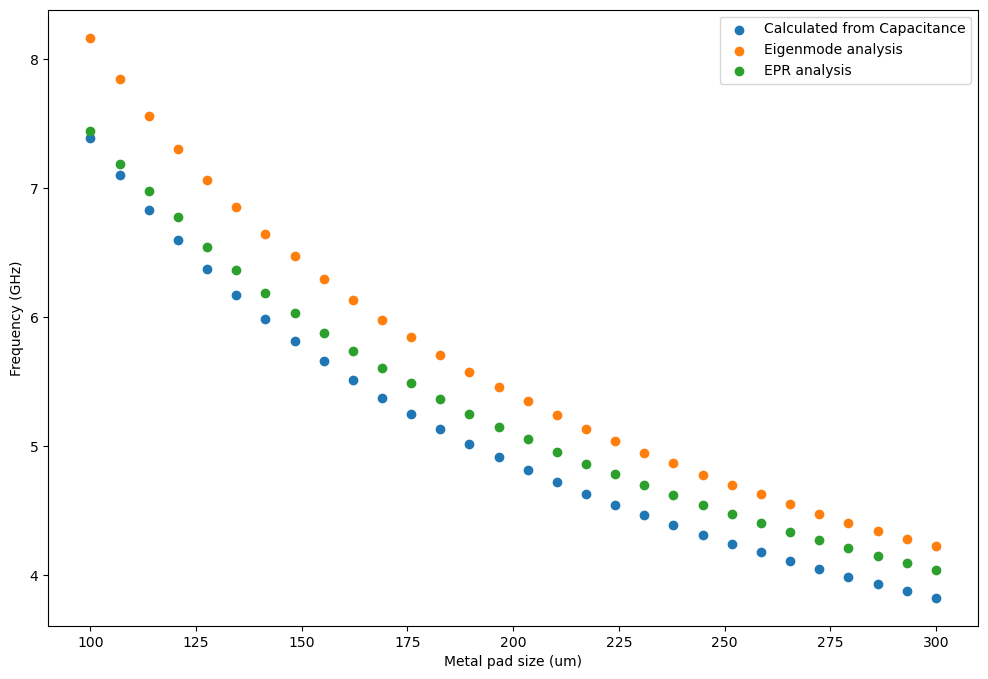

In [42]:
plt.figure(figsize = (12,8))

plt.scatter(sizes.value, plot_freq_from_cap1_s/1e9,label =  'Calculated from Capacitance')
# plt.scatter(gaps.value, plot_freq_from_cap1)
plt.scatter(sizes.value, np.array(plot_freq_s), label = 'Eigenmode analysis')
plt.scatter(sizes.value, np.array(freqs_s)/1e3, label = 'EPR analysis')
plt.xlabel('Metal pad size (um)')
plt.ylabel('Frequency (GHz)')
plt.legend()
plt.savefig('transmon frequency vs size.png')
plt.show()


In [61]:
dictionary1 = {}

dictionary1['Pad_len (mm)'] = sizes/1000
dictionary1['Pad_area (mm2)'] = sizes**2/1e6
dictionary1['Ground_Pad (fF)'] = plot_cap_s
dictionary1['Finite Element Analysis Freq (GHz)'] = plot_freq_s
dictionary1['Frequency from Capacitance (GHz)'] = plot_freq_from_cap1_s/1e9
dictionary1['EPR Frequency (GHz)'] = np.array(freqs_s)/1e3
df = pd.DataFrame(dictionary1)

In [62]:
df

,Pad_len (mm),Pad_area (mm2),Ground_Pad (fF),Finite Element Analysis Freq (GHz),Frequency from Capacitance (GHz),EPR Frequency (GHz)
0,0.100000,0.010000,30.19904,8.166929,7.391103,7.447307
1,0.106897,0.011427,32.96735,7.850295,7.100319,7.188378
2,0.113793,0.012949,35.80893,7.563763,6.835608,6.982504
3,0.120690,0.014566,38.68578,7.305986,6.596260,6.774675
4,0.127586,0.016278,41.60795,7.066407,6.377675,6.543367
5,0.134483,0.018086,44.61591,6.851792,6.174355,6.365159
6,0.141379,0.019988,47.66978,6.648107,5.986985,6.185004
7,0.148276,0.021986,50.70111,6.478095,5.817211,6.036151
8,0.155172,0.024078,53.77231,6.294934,5.659394,5.878684
9,0.162069,0.026266,56.83226,6.131919,5.514493,5.741360


In [63]:
df.to_csv('Frequencies from metal pad size.csv')

### Function that takes in frequency and construct qubit design automatically

In [32]:
def transmon_capacitance(Cq, lj =12*u.nH ):
    Cq *= u.fF
    # Cq = 100*u.fF
    Lj = lj
    Ec = (c.e.si**2/2/Cq).to(u.J)
    Ej = ((phi0/2/np.pi)**2/Lj).to(u.J)
    # epsilon1 = -Ec*2**9
    wq = (np.sqrt(8*Ej*Ec)-Ec)/c.hbar
    fq = wq/2/np.pi
    alpha = Ec/c.h
    
    return(fq)

In [33]:
def transmon_capacitance_optimzie(Cq, target_freq):
    Cq *= u.fF
    # Cq = 100*u.fF
    Lj = 12*u.nH
    Ec = (c.e.si**2/2/Cq).to(u.J)
    Ej = ((phi0/2/np.pi)**2/Lj).to(u.J)
    # epsilon1 = -Ec*2**9
    wq = (np.sqrt(8*Ej*Ec)-Ec)/c.hbar
    fq = wq/2/np.pi
    alpha = Ec/c.h
    
    return(fq-target_freq)

In [34]:
transmon_capacitance(120)

<Quantity 4.03268243e+09 1 / s>

In [35]:
target_freq = 4.5*u.GHz



target_cap = optimize.fsolve(transmon_capacitance_optimzie,100, args = (target_freq))[0]*u.fF


In [36]:
target_cap

<Quantity 95.4367639 fF>

In [37]:
def simulate_cap_minimize(width):
    return(find_Cap(width)-target_cap)

# width_45 = optimize.fsolve(simulate_cap_minimize, [250])

In [38]:
find_Cap(6*u.GHz)

UnitConversionError: 'GHz' (frequency) and 'um' (length) are not convertible

In [ ]:
type(2*u.m)

astropy.units.quantity.Quantity

NameError: name 'width' is not defined

In [ ]:
optimize.show_options()




minimize


bfgs
====

Minimization of scalar function of one or more variables using the
BFGS algorithm.

Options
-------
disp : bool
    Set to True to print convergence messages.
maxiter : int
    Maximum number of iterations to perform.
gtol : float
    Terminate successfully if gradient norm is less than `gtol`.
norm : float
    Order of norm (Inf is max, -Inf is min).
eps : float or ndarray
    If `jac is None` the absolute step size used for numerical
    approximation of the jacobian via forward differences.
return_all : bool, optional
    Set to True to return a list of the best solution at each of the
    iterations.
finite_diff_rel_step : None or array_like, optional
    If `jac in ['2-point', '3-point', 'cs']` the relative step size to
    use for numerical approximation of the jacobian. The absolute step
    size is computed as ``h = rel_step * sign(x) * max(1, abs(x))``,
    possibly adjusted to fit into the bounds. For ``method='3-point'``
    the sign of `h` is ignore